In [ ]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn

Requirement already up-to-date: mxnet~=1.7 in /usr/local/lib/python3.7/dist-packages (1.8.0.post0)
Requirement already up-to-date: gluonts in /usr/local/lib/python3.7/dist-packages (0.7.5)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

# Data visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
import folium

# Statistics 
import scipy
import statsmodels as sms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/dataset/country_vaccinations.csv')
data.tail(10)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
15656,Zimbabwe,ZWE,2021-04-27,433939.0,370676.0,63263.0,22329.0,15562.0,2.92,2.49,0.43,1047.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15657,Zimbabwe,ZWE,2021-04-28,458013.0,388021.0,69992.0,24074.0,17860.0,3.08,2.61,0.47,1202.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15658,Zimbabwe,ZWE,2021-04-29,477597.0,400771.0,76826.0,19584.0,17971.0,3.21,2.70,0.52,1209.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15659,Zimbabwe,ZWE,2021-04-30,500342.0,414735.0,85607.0,22745.0,19194.0,3.37,2.79,0.58,1291.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15660,Zimbabwe,ZWE,2021-05-01,520299.0,428135.0,92164.0,19957.0,21171.0,3.50,2.88,0.62,1424.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15661,Zimbabwe,ZWE,2021-05-02,524199.0,430068.0,94131.0,3900.0,19169.0,3.53,2.89,0.63,1290.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15662,Zimbabwe,ZWE,2021-05-03,537516.0,437751.0,99765.0,13317.0,17987.0,3.62,2.95,0.67,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15663,Zimbabwe,ZWE,2021-05-04,559777.0,452191.0,107586.0,22261.0,17977.0,3.77,3.04,0.72,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15664,Zimbabwe,ZWE,2021-05-05,576233.0,461023.0,115210.0,16456.0,16889.0,3.88,3.10,0.78,1136.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15665,Zimbabwe,ZWE,2021-05-06,607355.0,478174.0,129181.0,31122.0,18537.0,4.09,3.22,0.87,1247.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...


In [ ]:
data["date"] = pd.to_datetime(data["date"], format = '%Y-%m-%d')
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)

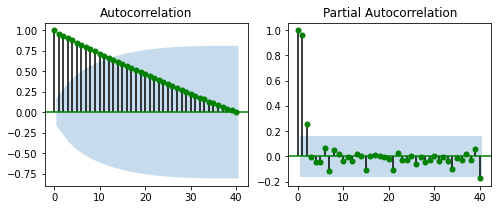

In [ ]:
plt.figure(figsize = (8,3))
plt.subplot(121); plot_acf(data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['total_vaccinations'], lags = 40, ax = plt.gca(), color = 'green')
plt.subplot(122); plot_pacf(data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['total_vaccinations'], lags = 40,ax = plt.gca(), color = 'green')
plt.show()

In [ ]:
result = adfuller(data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['total_vaccinations'].dropna())
print("ADF Statistics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")

ADF Statistics  3.0526736998311965
p-value 1.0
critical values 4584.850222121779
Reject the null hypotheise , it mean data is not stationary


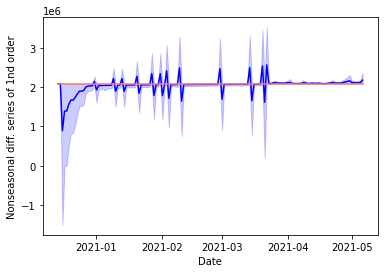

ADF Statistics  -12.436264519383535
p-value 3.841062696179127e-23
critical values 478709.8660042889
fail to reject null hypothese h1 , it mean data is stationary


In [ ]:
data['diff1'] = data[data['vaccines']=='Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']['total_vaccinations'].diff()
data['diff1'] = data['diff1'].fillna(data['diff1'].mean())
ax = sns.lineplot(x = data['date'], y = data['diff1'], color='blue')
sns.lineplot(x = data['date'], y = data['diff1'].mean(), color='salmon')
plt.xlabel('Date')
plt.ylabel('Nonseasonal diff. series of 1nd order')
plt.show()
result = adfuller(data.diff1)
print("ADF Statistics ",result[0])
print("p-value",result[1])
print("critical values",result[5])
if result[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")

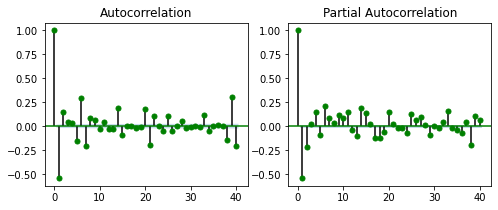

In [ ]:
plt.figure(figsize = (8,3))
plt.subplot(121); plot_acf(data['diff1'], lags = 40, ax = plt.gca(), color = 'green')
plt.subplot(122); plot_pacf(data['diff1'], lags = 40,ax = plt.gca(), color = 'green')
plt.show()

In [ ]:
data.tail()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,diff1
15661,Zimbabwe,ZWE,2021-05-02,524199.0,430068.0,94131.0,3900.0,19169.0,3.53,2.89,0.63,1290.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...,2.086155e+06
15662,Zimbabwe,ZWE,2021-05-03,537516.0,437751.0,99765.0,13317.0,17987.0,3.62,2.95,0.67,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...,2.086155e+06
15663,Zimbabwe,ZWE,2021-05-04,559777.0,452191.0,107586.0,22261.0,17977.0,3.77,3.04,0.72,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...,2.086155e+06
15664,Zimbabwe,ZWE,2021-05-05,576233.0,461023.0,115210.0,16456.0,16889.0,3.88,3.10,0.78,1136.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...,2.086155e+06
15665,Zimbabwe,ZWE,2021-05-06,607355.0,478174.0,129181.0,31122.0,18537.0,4.09,3.22,0.87,1247.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...,2.086155e+06


# ARIMA

15656    406555.739860
15657    428516.222326
15658    452171.676995
15659    472561.957670
15660    494840.646525
15661    515257.416561
15662    522428.275156
15663    534528.138912
15664    554776.902879
15665    571983.993715
Name: predicted_mean, dtype: float64


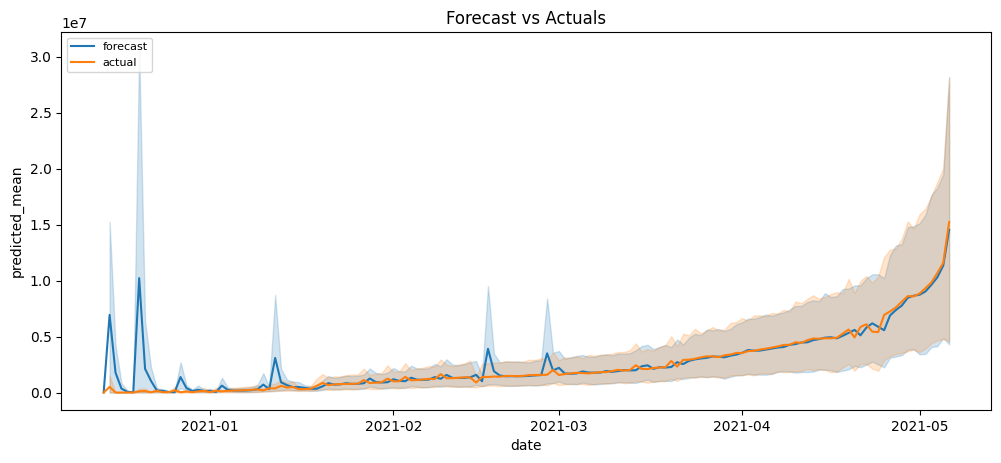

In [ ]:
train = data['total_vaccinations'][:100]
test = data['total_vaccinations'][100:]
model = ARIMA(data['total_vaccinations'], order = (0,1,1))
model = model.fit()
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start, end=end, typ = 'levels')
print(pred.tail(10))
plt.figure(figsize=(12,5), dpi=100)
ax = sns.lineplot(x=data['date'], y = pred, label='forecast')
sns.lineplot(x=data['date'], y = data['total_vaccinations'], label='actual', ax=ax)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
mean_squared_error(test, pred, squared = False)

4533622.574622663

In [ ]:
pred.mean()

3182782.711671191

In [ ]:
mean_absolute_percentage_error(test,pred)

7.173199716185583e+20

In [ ]:
from sklearn.metrics import r2_score
r2_score(test, pred)

0.9291889675312034

In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(test, pred))

445328.60153364454


In [ ]:
from sklearn.metrics import median_absolute_error
print(median_absolute_error(test, pred))

12824.36844128089


In [ ]:
from math import sqrt
rmse = sqrt(mean_squared_error(test, pred))
print(rmse)

4533622.574622663
